# Module 7. Time series analysis

The book by Rajagopalan (2021) does not tackle the topic of time series analysis. Specialized books do exist on how to do time series analysis in Python, but those are too detailed for the time we can spend on the subject within the scope of this course. Hence, this notebook, and specifically the Python code you can find here can be used as an introduction on the topic.

In [1]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

/tmp/ipykernel_25210/2839152206.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd                                 # Dataframe


In Python, a time series can be represented by an instance of the Pandas [`Series`](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) class.

<Axes: >

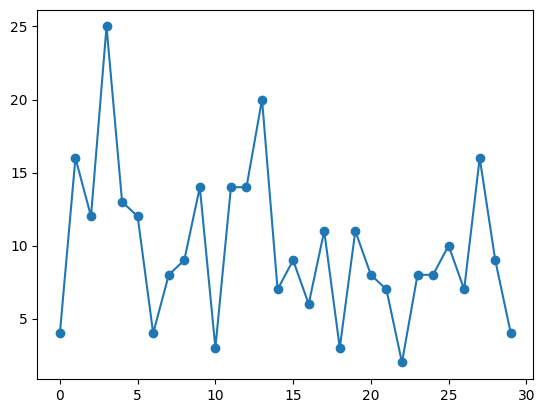

In [2]:
demand_ts = pd.Series(
    data=[4, 16, 12, 25, 13, 12, 4,  8, 9, 14,
          3, 14, 14, 20,  7,  9, 6, 11, 3, 11,
          8,  7,  2,  8,  8, 10, 7, 16, 9,  4]
)
demand_ts.plot(marker='o')

Columns in a `DataFrame` can also be processed as time series with the time/date as index. Let's create a `DataFrame` with this time series as a column and add a `DateTime` index:

<Axes: >

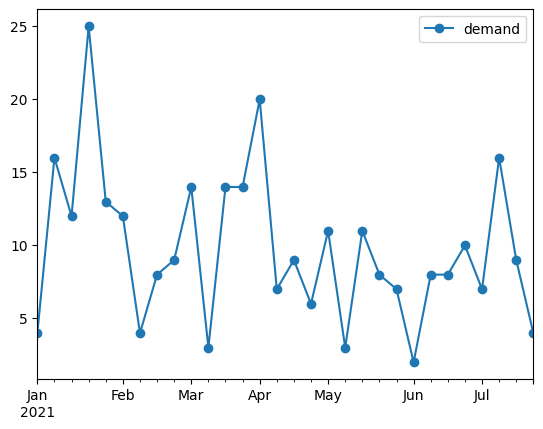

In [4]:
dates = pd.date_range("2021-01-01", periods=30, freq='W')

demand_df = pd.DataFrame(data=demand_ts.values, columns=['demand'], index=dates)
demand_df.plot(marker='o')

A `DateTime` index allows us to select observations between a start and end date:

<Axes: >

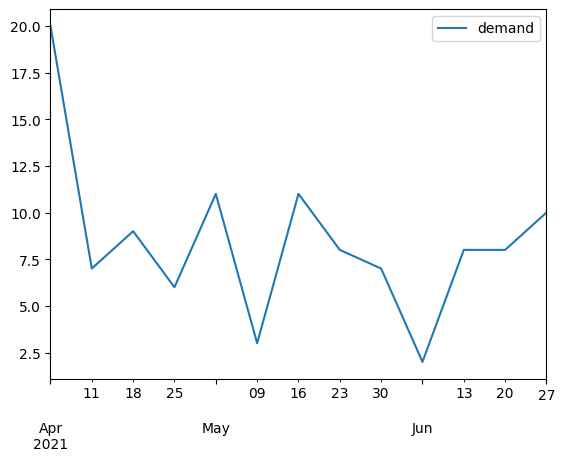

In [5]:
# Only select observations for Q2 (April-June) using DateTime
start_date = pd.to_datetime("2021-04-01")
end_date = pd.to_datetime("2021-06-30")
demand_q2 = demand_df[start_date:end_date]
demand_q2.plot()


## Time series models

In the chart below, we attempt to model observed values with a constant function $X_t = b + \varepsilon_t$ (with $\varepsilon_t$ some random noise with constant variance). As an estimate for $b$, we take the average of the first observations. We can basically use our own judgement to choose how many.

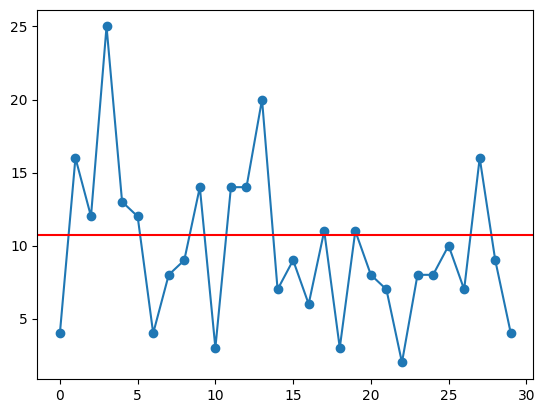

In [6]:
b_est_20 = demand_ts[0:20].mean()
b_est_30 = demand_ts[0:30].mean()

demand_ts.plot(marker='o')             # Plot the time series
plt.axhline(y=b_est_20, color='red')   # Mean of first 20 observations
#plt.axhline(y=b_est_30, color='blue')  # Mean of first 30 observations

If we want to model these values with a linear function $X_t = b_0 + b_1 t + \varepsilon_t$, we can use a technique we actually already used in another context: linear regression.

In [8]:
# Build a linear regression model
demand_lm = LinearRegression().fit(
    demand_ts.index.values.reshape((-1,1)),
    demand_ts.values
)
# plot the time series and the regression line
demand_ts.plot(marker='o')
plt.axline((0, demand_lm.intercept_), slope=demand_lm.coef_)

Error in callback <function _draw_all_if_interactive at 0x7acdb8780940> (for post_execute), with arguments args (),kwargs {}:


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

<Figure size 640x480 with 1 Axes>

We can also use Seaborn's `regplot()` function to draw the regression line. We don't get the parameters, though...

<Axes: >

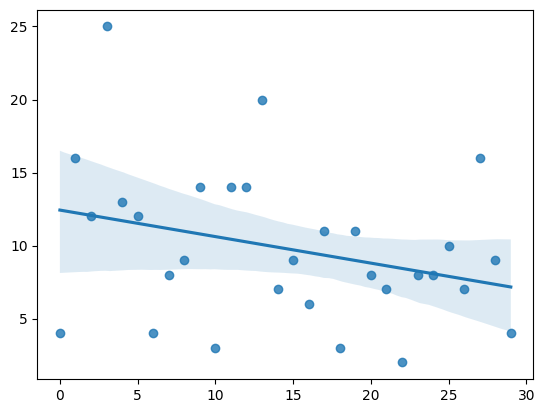

In [9]:
sns.regplot(x=demand_ts.index, y=demand_ts.values)

This estimate doesn't seem useful. If we use the regression line to make a forecast of weekly demand in the future, we would expect that the demand will soon drop to zero.

Maybe it's useful to adapt our model when new observations are added?

## Moving average

We basically need a method that takes the last observations into account, but forgets observations after some time. Older observations may no longer be representative of the current demand. Moving averages are such methods.

We will use the `DataFrame` created earlier to store moving averages as new columns next to the observations.

### Simple Moving Average

$$SMA(t) = \frac{1}{m} \sum_{i=k}^{t} x_i$$

With $m$ the time range (the number of observations taken into account) and $k$ = t - m + 1.

The Pandas `Series` class has a method [`rolling()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.rolling.html) for "rolling window" calculations, which is perfectly suitable for what we want to do here.

We call the method `rolling(m)` with the desired time range and then calculate the `mean()`:

In [10]:
demand_df['SMA3'] = demand_df.demand.rolling(3).mean()
demand_df['SMA5'] = demand_df.demand.rolling(5).mean()
demand_df['SMA10'] = demand_df.demand.rolling(10).mean()
demand_df

,demand,SMA3,SMA5,SMA10
2021-01-03,4,NaN,NaN,NaN
2021-01-10,16,NaN,NaN,NaN
2021-01-17,12,10.666667,NaN,NaN
2021-01-24,25,17.666667,NaN,NaN
2021-01-31,13,16.666667,14.0,NaN
2021-02-07,12,16.666667,15.6,NaN
2021-02-14,4,9.666667,13.2,NaN
2021-02-21,8,8.000000,12.4,NaN
2021-02-28,9,7.000000,9.2,NaN
2021-03-07,14,10.333333,9.4,11.7


You'll notice that the first data points in the SMA columns are empty (`NaN`). At those time slots there are still not enough past observations to calculate the mean. The larger the time window, the more empty data points.

If you want to avoid empty cells, you can add the parameter `min_periods=1` to the method call of `rolling()`. In that case the mean will be calculated with any available past observation.

<Axes: >

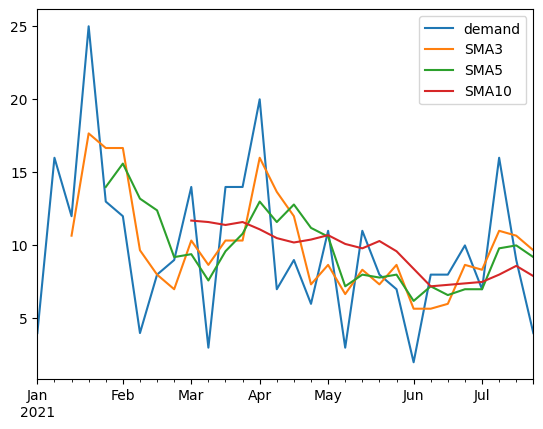

In [11]:
demand_df.plot()

As you will notice, SMA's with a short window will still follow fluctuations in the observations, while those with a longer window are more "stable", and resilient to short-term fluctuations.

### Exponential Moving Average (EMA)

Also called *Single Exponential Smoothing* (SES).

$X_t = \alpha x_{t-1} + (1 - \alpha) X_{t-1}$

Pandas has a method [`ewm()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html) that can be used to calculate the exponential moving average.

<Axes: >

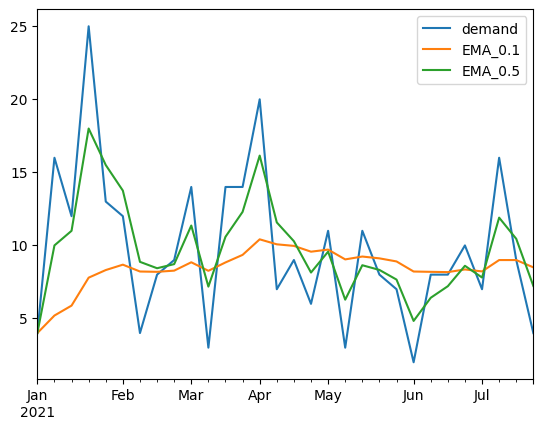

In [12]:
demand_df['EMA_0.1'] = demand_df.demand.ewm(alpha=.1, adjust=False).mean()
demand_df['EMA_0.5'] = demand_df.demand.ewm(alpha=.5, adjust=False).mean()
demand_df[['demand', 'EMA_0.1', 'EMA_0.5']].plot()

Play with the values of alpha. What is the effect if alpha is small (close to 0) or large (close to 1)?

Unfortunately, the `ewm()` method does not allow us to do double or triple exponential smoothing. Statsmodels does have the necessary classes. For Single Exponential Smoothing, we can instantiate the [`SimpleExpSmoothing`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing) class and then call the [`fit()`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit) method. The parameter $\alpha$ can be set with argument `smoothing_level`.

/home/codespace/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: >

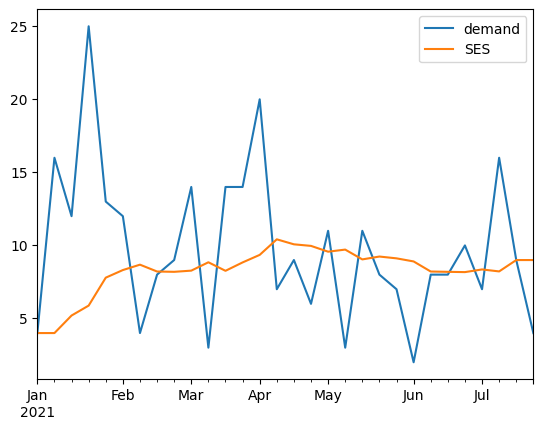

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
demand_ses = SimpleExpSmoothing(demand_df.demand).fit(smoothing_level=0.1)

demand_df['SES'] = demand_ses.fittedvalues

demand_df.demand.plot(legend=True)
demand_df.SES.plot(legend=True)

These statsmodels classes allow us to do a prediction based on the model:

<Axes: >

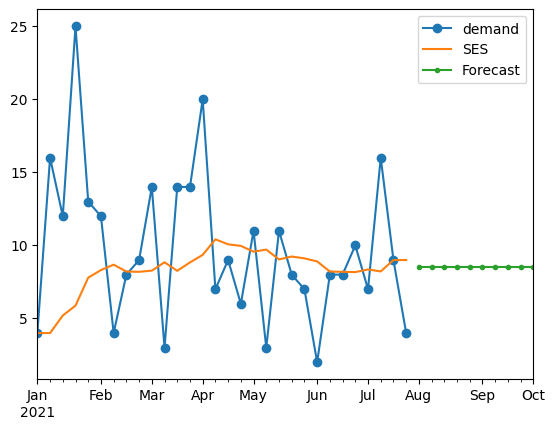

In [14]:
demand_ses_fcast = demand_ses.forecast(10)

demand_df.demand.plot(marker='o', legend=True) # Observations
demand_df.SES.plot(legend=True)                # SES fitted valuis
demand_ses_fcast.plot(marker='.', legend=True, label='Forecast')

When we use Single Exponential Smoothing, we assume that the underlying time series fluctutates around some constant value. This is reflected by the forecasted values (in green), which are always the same:

In [15]:
demand_ses_fcast.values

array([8.49791087, 8.49791087, 8.49791087, 8.49791087, 8.49791087,
       8.49791087, 8.49791087, 8.49791087, 8.49791087, 8.49791087])

In [16]:
demand_ses.params_formatted

,name,param,optimized
smoothing_level,alpha,0.1,False
initial_level,l.0,4.0,False


### Double exponential smoothing

If we suspect that there is a long-term (increasing or decreasing) trend in the time series, we can use Double Exponential Smoothing (DES), also called Holt's Method.

$$X_{t} = \alpha x_{t} + (1-\alpha)(X_{t-1} + b_{t-1})$$

$$b_{t} = \beta(X_{t}-X_{t-1}) + (1-\beta)b_{t-1}$$

with smoothing parameters $0 < \alpha < 1$ and $0 < \beta < 1$. $b_t$ is an estimate for the trend at time $t$ and can also be interpreted as the slope of a regression line.

In Python, you can instantiate the class [`Holt`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.html#statsmodels.tsa.holtwinters.Holt) and call the [`fit()`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.fit.html#statsmodels.tsa.holtwinters.Holt.fit) method. The smoothing parameters $\alpha$ and $\beta$ can be set with arguments `smoothing_level` and `smoothing_trend`, respectively. If you don't specify these, suitable values will be calculated using some rule of thumb.

/home/codespace/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: >

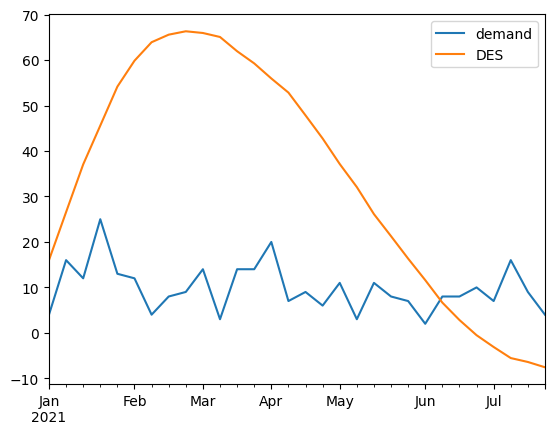

In [17]:
from statsmodels.tsa.api import Holt

demand_des = Holt(demand_df.demand).fit(smoothing_level=.1, smoothing_trend=.2)

demand_df['DES'] = demand_des.fittedvalues

demand_df.demand.plot(legend=True)
demand_df.DES.plot(legend=True)

We can retrieve the parameters of the model (smoothing parameters, initial estimate of constant term and trend):

In [18]:
demand_des.params_formatted

,name,param,optimized
smoothing_level,alpha,0.1,False
smoothing_trend,beta,0.2,False
initial_level,l.0,4.0,False
initial_trend,b.0,12.0,False


To use this model for forecasting:

<Axes: >

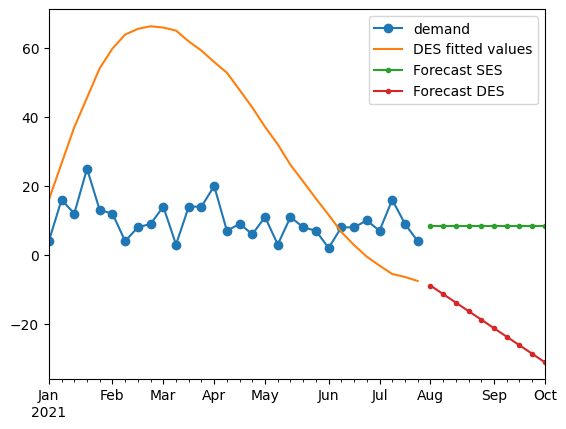

In [19]:
demand_des_fcast = demand_des.forecast(10)

demand_df.demand.plot(marker='o', legend=True) # Observations
demand_df.DES.plot(legend=True, label='DES fitted values')              
demand_ses_fcast.plot(marker='.', legend=True, label='Forecast SES')
demand_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

As we can see, the predictions are now decreasing:

In [35]:
demand_des_fcast

2021-08-01    6.940416
2021-08-08    6.852768
2021-08-15    6.765120
2021-08-22    6.677472
2021-08-29    6.589825
2021-09-05    6.502177
2021-09-12    6.414529
2021-09-19    6.326881
2021-09-26    6.239233
2021-10-03    6.151586
Freq: W-SUN, dtype: float64

### Triple Exponential Smoothing

Triple Exponential Smoothing (TES), also called *Holt-Winter's Method*, can in addition also model seasonally recurring trends.

- Level smoothing: $X_{t} = \alpha \frac{x_{t}}{c_{t-L}} + (1-\alpha) (X_{t-1} + b_{t-1})$
- Trend smoothing: $b_{t} = \beta (X_{t} - X_{t-1}) + (1-\beta)b_{t-1}$ 
- Seasonal smoothing: $c_{t} = \gamma \frac{x_{t}}{X_{t}} + (1-\gamma)c_{t-L}$

In these formulas, the following additional notation is used:

- $L$ is the length (in number of time units) of the seasonal cycle. Common values are 7 for a weekly cycle, 4 for a quarterly one, 12 for a monthly cycle, etc.
- $0 < \gamma < 1$ is the smoothing parameter for the seasonal trend (like $\alpha$ and $\beta$). Set this value in the `fit()` method using argument `smoothing_seasonal`.
- $c_t$ are estimates for the seasonal correction factors, one for each time unit $t\mod L$ within the seasonal cycle.

The example dataset used in the previous sections is not suitable for this, as it has no seasonal trend. Instead, we will use a demo dataset from Seaborn with air passenger data for 12 years from 1949 to 1960.

The dataset has two columns for the date (year and month). To make our lives a bit easier, we'll add a column with the date using Pandas' `date_range()` function. The `freq='MS'` parameter denotes that we want each consecutive date in the range to be the first day of the next month.

In [36]:
# Load the dataset
flights = sns.load_dataset('flights')
# Add a column for the date (last day of each month)
flights['date'] = pd.date_range(start="1949-01-01", freq='MS',
    periods=len(flights))

# Only keep the useful columns and set the index
flights = flights[['date', 'passengers']].set_index(['date'])
flights.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='date'>

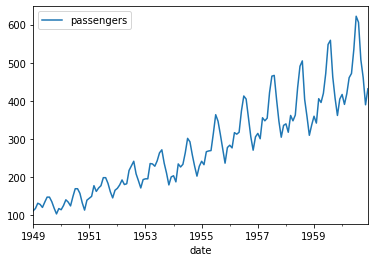

In [37]:
flights.plot()

Now we will fit the data with Holt-Winters Exponential Smoothing. We will train the model on the data from the first ten years and use the last two years as test data to check how the model performs.

The `ExponentialSmoothing` class allows us to train a model for all three types of Exponential Smoothing. It is in fact a superclass for `SimpleExpSmoothing` and `Holt`! When you add the parameter `trend`, it will enable Double Exponential Smoothing, and with `seasonal`, it will enable Triple Exponential Smoothing. When you don't specify either, a Single Exponential Smoothing model will be built.

The value of `trend` and `seasonal` is a string and can be either `add`/`additive` or `mul`/`multiplicative`. When the long term or seasonal trend remains constant over time, use `add`. If, however, you see that the trend grows over time, use `mul`.

In this case, the long term trend looks linear, so we'll specify `trend='add'`. The seasonal trend, however, seems to grow over time, so we'll specify `season='mul'`.

The initial values for the level, trend and seasonal correction factors are calculated automatically using some rule of thumb. If you want to set them manually, though, you can by specifying arguments `initial_level`, `initial_trend` and `initial_seasonal` in the constructor call. See the [API documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit) for details.

If you want to set parameters $\alpha$, $\beta$ and $\gamma$ manually, you can add arguments to the [`fit()`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit) method call, specifically `smoothing_level` for $\alpha$, `smoothing_trend` for $\beta$ and `smoothing_seasonal` for $\gamma$. Again, if we don't specify them, a suitable value will be calculated automatically.

<AxesSubplot:xlabel='date'>

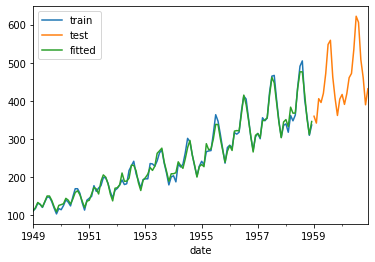

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = flights.passengers[:120]
test = flights.passengers[120:]

passengers_hw = ExponentialSmoothing(train,
  trend='add', seasonal='mul',
  seasonal_periods=12, freq='MS').fit()

train.plot(legend=True, label='train')
test.plot(legend=True, label='test')
passengers_hw.fittedvalues.plot(legend=True, label='fitted')

Our model seems to fit the data well. Let's use it to make a forecast. Generally, a forecast for $m$ time units after the last observation (time unit $t$) is calculated as follows:

$$F_{t+m} = (X_{t} + m b_{t})c_{t-L+1+(m-1) \mod L}$$

Applied to the airline passengers case, we calculate a forecast for the last two years (i.e. the test data) as follows:

Text(0.5, 1.0, 'Train, test, fitted & predicted values using Holt-Winters')

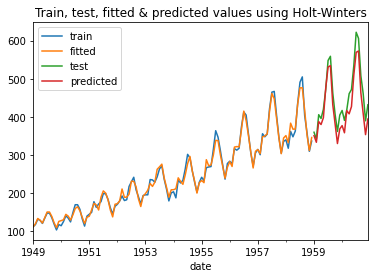

In [39]:
passengers_predicted = passengers_hw.forecast(24)

train.plot(legend=True, label='train')
passengers_hw.fittedvalues.plot(legend=True, label='fitted')

test.plot(legend=True, label='test')
passengers_predicted.plot(legend=True, label='predicted')

plt.title('Train, test, fitted & predicted values using Holt-Winters')

Let's zoom in on the forecasted period to compare test data and predictions:

Text(0.5, 1.0, 'Test data vs. predicted values')

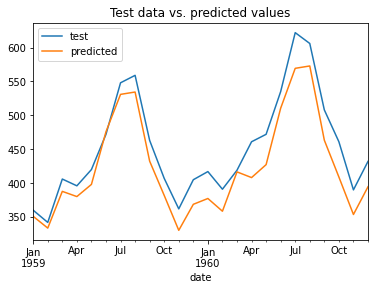

In [40]:
test.plot(legend=True, label='test')
passengers_predicted.plot(legend=True, label='predicted')
plt.title('Test data vs. predicted values')

In [41]:
passengers_predicted

1959-01-01    350.959395
1959-02-01    333.629324
1959-03-01    387.807141
1959-04-01    380.139165
1959-05-01    398.088738
1959-06-01    475.827941
1959-07-01    530.929437
1959-08-01    534.389339
1959-09-01    432.384028
1959-10-01    381.846818
1959-11-01    330.353490
1959-12-01    368.715038
1960-01-01    377.317009
1960-02-01    358.529584
1960-03-01    416.572032
1960-04-01    408.162086
1960-05-01    427.255680
1960-06-01    510.479069
1960-07-01    569.359992
1960-08-01    572.838411
1960-09-01    463.308447
1960-10-01    408.994974
1960-11-01    353.702291
1960-12-01    394.622574
Freq: MS, dtype: float64

### Model internals

We can retrieve the internals of the model. These are the relevant attributes:

- `level` contains all level estimates ($X_i$) for each time unit in the training data
- `trend` contains all trend estimates ($b_i$)
- `season` contains all estimates for the seasonal adjustment factors. ($c_i$)
- `params` (dict output) or `params_formatted` (table output) contains all parameters used to bootstrap the model (including automatically calculated ones).

In [42]:
# Retrieve the automatically calculated parameters of the model:
passengers_hw.params_formatted

,name,param,optimized
smoothing_level,alpha,3.642084e-01,True
smoothing_trend,beta,4.191163e-09,True
smoothing_seasonal,gamma,6.357916e-01,True
initial_level,l.0,1.108939e+02,True
initial_trend,b.0,2.389331e+00,True
initial_seasons.0,s.0,9.886767e-01,True
initial_seasons.1,s.1,1.039122e+00,True
initial_seasons.2,s.2,1.142171e+00,True
initial_seasons.3,s.3,1.086896e+00,True
initial_seasons.4,s.4,1.006128e+00,True


Forecasting is done using the final values for the level, trend and seasonal adjustment factor estimates. Let's retrieve them from the model:

In [43]:
# Model internals: last estimate for level, trend and seasonal factors:
print(f'level: {passengers_hw.level[119]}')
print(f'trend: {passengers_hw.trend[119]}')
print(f'seasonal factor: {passengers_hw.season[108:120]}')

level: 379.3864390419959
trend: 2.3893311224129845
seasonal factor: date
1958-01-01    0.919281
1958-02-01    0.868453
1958-03-01    1.003241
1958-04-01    0.977363
1958-05-01    1.017263
1958-06-01    1.208537
1958-07-01    1.340353
1958-08-01    1.340998
1958-09-01    1.078559
1958-10-01    0.946853
1958-11-01    0.814342
1958-12-01    0.888423
dtype: float64


The model performs forecasts by:

- Taking the last level estimate
- Taking the last trend estimate
- Taking the last estimate for the appropriate seasonal adjustment factor
- Computing the forecast formula given above

Let's verify this for the first forecasted value, for 1959-01-01:

In [44]:
# Predicted value by forecast():
print(passengers_predicted[0])

# Computed manually from model internals:
(passengers_hw.level[119] + passengers_hw.trend[119]) * passengers_hw.season[108]

350.95939498203336


350.95939498203336

### How to choose the appropriate model

In order to calculate forecasts of a time series using Exponential Moving Average, we need to make a few decisions, a.o. which of the three versions (single/double/triple exponential smoothing) to choose. A rule of thumb:

- If the data seems to fluctuate around the same level, without seasonally recurring patterns, choose **Single Exponential Smoothing**
- If there is a upward or downward trend in the data, choose **Double Exponential Smoothing**, a.k.a. **Holt's method**
    - If the trend seems to be linear, use the *additive* model
    - If the trend seems to increase over time, use the *multiplicative* model
- If there are seasonally recurring patterns in the observations, choose **Triple Exponential Smoothing**, a.k.a. **Holt-Winters' method**
    - If the seasonal patterns stay the same, choose the *additive* variant
    - If they increase or decrease over time, choose *multiplicative*

### Evaluating the quality of a model

How well did our model perform? We can compare the $m$ forecasted values with the observed values in the test set.

Two commonly used metrics for this are the Mean Absolute Error (MAE) and Mean Squared Error (MSE).

$$MAE = \frac{1}{m} \sum_{i=t+1}^{t+m} \left| x_i - F_i \right|$$

$$MSE = \frac{1}{m} \sum_{i=t+1}^{t+m} (x_i - F_i)^{2}$$

Remark the similarities between the formula for MSE and variance!

Applied to our case, we get:

In [45]:
passengers_predicted

1959-01-01    350.959395
1959-02-01    333.629324
1959-03-01    387.807141
1959-04-01    380.139165
1959-05-01    398.088738
1959-06-01    475.827941
1959-07-01    530.929437
1959-08-01    534.389339
1959-09-01    432.384028
1959-10-01    381.846818
1959-11-01    330.353490
1959-12-01    368.715038
1960-01-01    377.317009
1960-02-01    358.529584
1960-03-01    416.572032
1960-04-01    408.162086
1960-05-01    427.255680
1960-06-01    510.479069
1960-07-01    569.359992
1960-08-01    572.838411
1960-09-01    463.308447
1960-10-01    408.994974
1960-11-01    353.702291
1960-12-01    394.622574
Freq: MS, dtype: float64

In [46]:
test

date
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: passengers, dtype: int64

In [47]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MAE = {mean_absolute_error(test,passengers_predicted)}')
print(f'MSE = {mean_squared_error(test,passengers_predicted)}')

MAE = 28.97682834647434
MSE = 1055.4818963105765


In order to evaluate whether our model performs well, we can compare MSE with the variance in the data, or the square root of the MSE with the standard deviation:

In [48]:
print(f'√MSE  = {np.sqrt(mean_squared_error(test,passengers_predicted))}')
print(f'stdev = {flights.passengers.std()}')

√MSE  = 32.48818087105796
stdev = 119.9663169429432


The square root of the MSE is well within one standard deviation of the original data, which is an indicator that the model performs well.

A data scientist could try to tweak the parameters (like $\alpha$, $\beta$ and $\gamma$, but also initial values of the estimators like $X_t$, $b_t$ and $c_t$) of the model to attain an even lower MSE. When we are satisfied with the model's performance, we can start using it "in production". We could retrain the model with these parameters on the entire dataset and make forecasts for time units.

### Decomposing a time series

A data series that shows a long term and seasonal trend can be "decomposed":

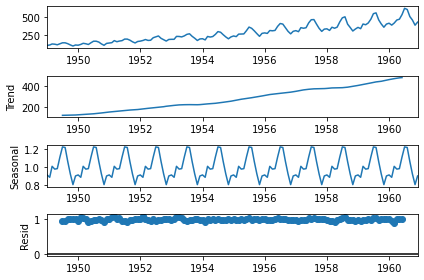

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

passengers_decomposed = seasonal_decompose(flights, model='multiplicative')
passengers_decomposed.plot();

- The top graph shows the observations
- The second graph is the long term trend (which seems to be linear, so the choice for an additive model was appropriate)
- The third graph shows the seasonal trend
- The final graph are the residues

The semicolon at the end of line 4 is not strictly necessary, but if you leave it out, it's possible that the plot is shown twice.

## Sources

Khan, E. (2021-01-05) *Python Code on Holt-Winters Forecasting.* Retrieved 2022-04-15 from <https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873>

Moreno, A.I. (2020-07-08) *Moving Averages with Python: Simple, cumulative and exponential moving averages with Pandas*, retrieved 2022-04-15 from <https://towardsdatascience.com/moving-averages-in-python-16170e20f6c>

Paramita (2020-12-17) *Holt winters Model, Easiest Times series Model. Additive multiplicative trend and seasonality*, retrieved 2022-04-16 from <https://www.youtube.com/watch?v=O6cUkdQeLUQ>

Perktold, J., et al. (2022-04-13) *statsmodels manual: Exponential Smoothing.* Retrieved 2022-04-15 from <https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html>